In [18]:
import numpy as np
import gpkit
import astropy.constants as const
import matplotlib.pyplot as plt
from gpkit import Model, Variable
from gpkit.nomials.math import SingleSignomialEquality,SignomialInequality
from gpkit.constraints.bounded import Bounded
gpkit.SIGNOMIALS_ENABLED = True
from collections import OrderedDict

In [14]:
muval = 3.986005e14
alpha_1 = Variable("\\alpha_1", 0.6624)
alpha_2 = Variable("\\alpha_2", 0.06991)
alpha_3 = Variable("\\alpha_3", 1266.75, "s")
alpha_4 = Variable("\\alpha_4", 804.90, "s")

R_earth = Variable("R_{earth}", const.R_earth.value/1000, "km", "earth radius")
eta_s = Variable("\\eta_s", 0.29, "-", "solar panel efficiency")
Q_s = Variable("Q_s", 1367, "W/m^2", "solar flux constant")
EbNo_req = Variable("EbNo_{req}", 40, "-", "ebno required")

G_Rx = Variable("G_{Rx}", "-", "ground receive gain")
D_Rx = Variable("D_{Rx}", 5.3, "m", "ground receive diamater")

D_Tx = Variable("D_{Tx}", "m", "spacecraft antenna diameter")
L_other = Variable("L_{other}", 9.772372209558107, "-", "line loss") #1.58489
k = Variable("k", const.k_B.value, "J/K", "Boltzman constant R/Na")
T_sys = Variable("T_{sys}", 135, "K", "system temperature")
N = Variable("N", 2000, '-', 'number of pixels along width')
B_ppx = Variable("B_{ppx}", 8, "bit", "bit per pixel")
eta = Variable("\\eta", 0.55, "-", "dish efficiency")
lambda_obs = Variable("\\lambda_{obs}", 500, "nm", "image payload wavelength")
e = Variable("e", 25, 'W/kg', 'power density of solar arrays') 
A_rho = Variable("A_{rho}", 10, "kg/m^2", "solar panel area density")

f = Variable("f", 2.2, "GHz", "transmit frequency")
lambda_com = Variable("\\lambda_{com}", "m", "transmit wavelength") #fake variable    
c = Variable("c", const.c.value, "m/s", "Speed of light in vacuum")
D_rho = Variable("D_{rho}", 100, "kg/m^1.5")
DTx_rho = Variable("DTx_{rho}", 2, "kg/m^1.5")
h_min = Variable('h_{min}', 400, 'km', 'minimum orbit altitude')

prop_rho = Variable('prop_{rho}', 500, 'kg*km', 'propellant altitude constant')
a_const = Variable('a_const', 200, 'km', 'altitude constant')
alpha_5 = Variable("\\alpha_5", 0.058823529411764705, "year/km")
alpha_6 = Variable("\\alpha_6", 1., "year/kg")
T = Variable("T", 3, "year", "lifetime")
P_load = Variable("P_{load}", 5, "W", "constant power drain")
m_extra = Variable("m_{extra}", 0.2, "kg", "constant mass")

mu = Variable("mu", muval, "m^3/s^2", "standard gravitational parameter")

####
Xp_req = Variable('Xp_{req}', 20, 'm', 'required resolution')
m_total = Variable("m_{total}", 'kg', 'spacecraft total mass')
h = Variable("h", "km", "orbit altitude")
d_f = Variable("d_f", "-", "not in-eclipse orbit fraction")
e_f = Variable("e_f", "-", "in-eclipse orbit fraction")
P_suppl = Variable("P_{suppl}", "W", "spacecraft total power")
P_Tx = Variable("P_{Tx}", "W", "transmit power")
r = Variable("r", "km", "max distance to ground station")
GS_f = Variable("GS_f", "-", "downlink orbit fraction")
P = Variable("P", "min", "period")
P2 = Variable("P2", "min", "actual period")
D = Variable("D", "m", "aperture")
A = Variable("A", "m^2", "surface area solar panels")
m_p = Variable("m_p", "kg", "propellant mass")
E_battery = Variable("E_{battery}", "J", "battery energy")
battery_rho = Variable("b_{rho}", 0.1, "kg/kJ")

a = Variable("a", "km", "orbit semi-major axis")
dummy = Variable("dummy", "km", "formulation variable for altitude")
dummy_bound = Variable("dummy_{bound}", 6790, "km")

constraints = [
    lambda_com == c/f,
    G_Rx == eta*(np.pi*D_Rx/lambda_com)**2,
    P_suppl == d_f*A*eta_s*Q_s,
    P_Tx + P_load <= P_suppl,
    E_battery >= P_suppl*e_f*P,
    EbNo_req == P_Tx*G_Rx*Xp_req*GS_f*P*eta*D_Tx**2/
    (L_other*k*T_sys*R_earth*2*np.pi*N*B_ppx*(4*r**2)),
    Xp_req == h*lambda_obs/D,
    e_f >= 1-d_f,
    d_f <= GS_f + 0.5,
    a <= R_earth+h,
    #GS_f <= alpha_1*h/R_earth + alpha_2,
    GS_f**0.133355 <= 0.295066*(h/R_earth)**0.0619879+0.294791*(h/R_earth)**0.061991+
    0.294739 * (h/R_earth)**0.0619928,
    P == 2*np.pi*(a**3/mu)**0.5,
    r**2 >= h**2 + 2*R_earth*h,
    battery_rho*E_battery+D_rho*D**1.5 + DTx_rho*D_Tx**1.5 + 
    A_rho*A + prop_rho/h + m_extra<= 0.8*m_total
    #h >= h_min,
    #T >= alpha_6*m_p + alpha_5*a
]

In [22]:
m = Model(m_total, Bounded(constraints))
m.substitutions.update({'Xp_{req}':('sweep', np.linspace(5, 50,50))})
sol = m.localsolve()

Solving over 50 passes.
Sweeping took 18.5 seconds.


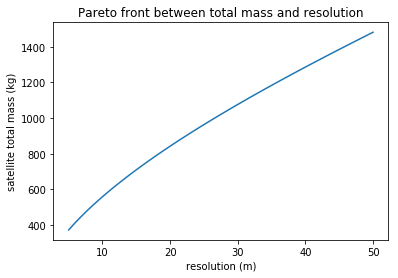

In [24]:
plt.plot(sol["variables"]["Xp_{req}"], sol["variables"]["m_{total}"])
plt.xlabel('resolution (m)')
plt.ylabel('satellite total mass (kg)')
plt.title('Pareto front between total mass and resolution')
plt.show()